# 摘要

# 理论模型

煤焦加工包括三种模式：独立焦化企业模式、煤矿企业模式以及自有焦化厂的钢铁企业模式。

煤焦加工套利的难点在于配煤炼焦工艺的确定、产成品质量及升贴水的确定、以及副产品构成及其价值的确定。

一级冶炼焦的配煤比例是主焦煤占比 35%，1/3 焦煤占比 25%、气煤占比 12%，肥煤占比 18%，瘦煤占比 10%。企业为了降低炼焦成本，一般是提高价格较低的瘦煤比重而降低主焦煤比重，因此企业为了应对市场变化带来的成本压力会改变原料的配比，那么炼焦成本也是在变化的，配煤的比例是动态变化的，并不是固定的。

一般的炼焦工艺是平均 1.33 吨炼焦煤加工产生 1 吨焦炭和若干副产品。

炼焦利润公式：炼焦利润 = 焦炭价格 - 1.33 * 焦煤价格 - 其他成本


# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

from WindPy import w

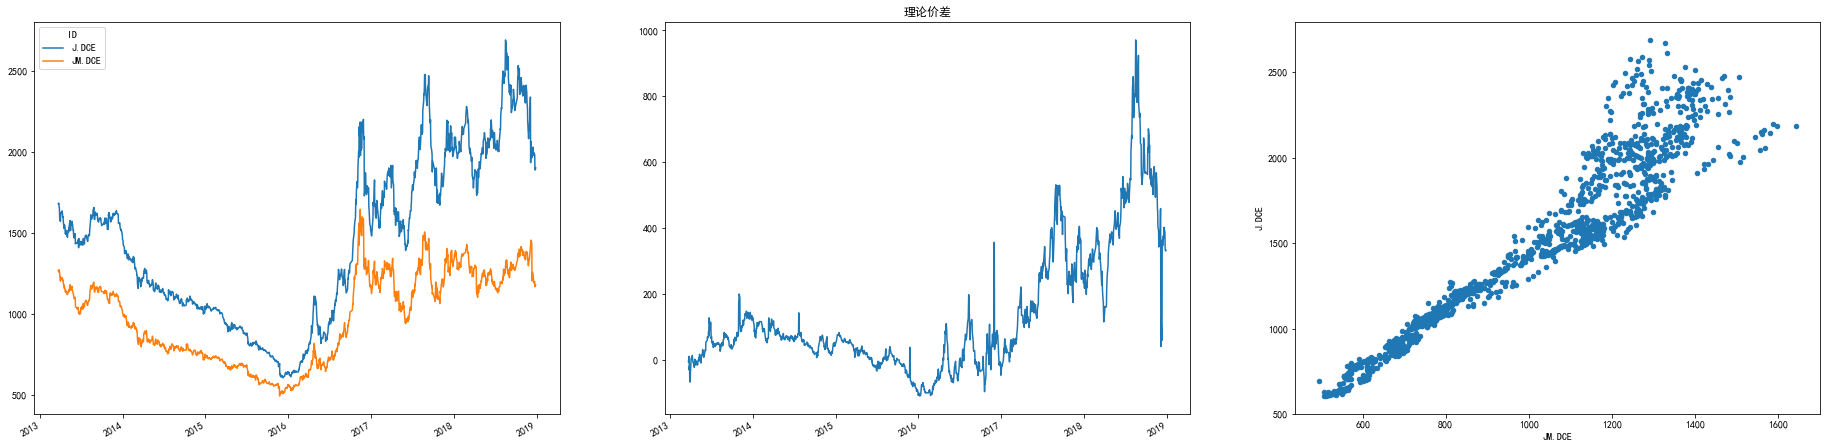

In [97]:
# 参数设置和数据准备
Exchange = "DCE"
IDs = ["J.DCE", "JM.DCE"]# 焦炭，焦煤主力合约
# IDs = ["J01.DCE", "JM01.DCE"]# 焦炭，焦煤连一合约
# IDs = ["J05.DCE", "JM05.DCE"]# 焦炭，焦煤连五合约
# IDs = ["J09.DCE", "JM09.DCE"]# 焦炭，焦煤连九合约
TheoryHedgeRatio = np.array([1, -1.33])
StartDT = dt.datetime(2013, 3, 22)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()

# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差")
CCPrice.plot(kind="scatter", x=CCPrice.columns[1], y=CCPrice.columns[0], ax=Axes[2]);

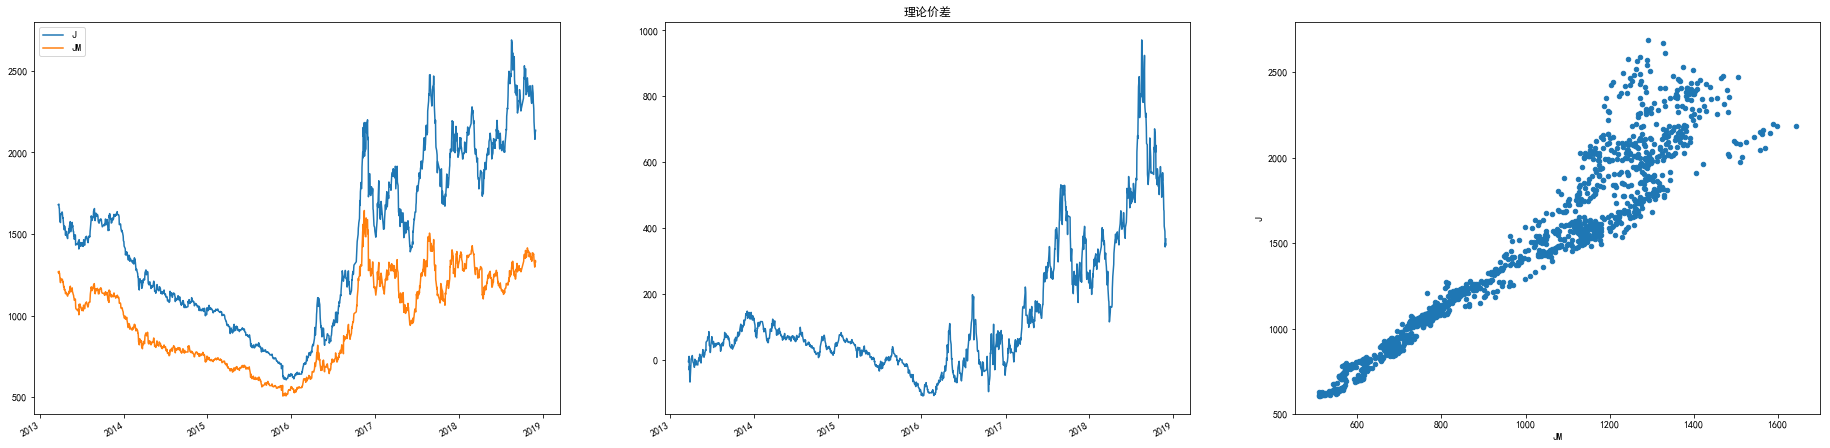

In [98]:
# 使用对齐交割月的价格数据
import re
Exchange = "DCE"
BenchmarkID = "J.DCE"# 作为标准的主力合约
Codes = ["J", "JM"]# 合约代码
ExchangeSuffix = ["DCE", "DCE"]# 交易所后缀
StartDT = dt.datetime(2013, 3, 22)# 回测开始日期
EndDT = dt.datetime(2018, 11, 30)# 回测截止日期
TheoryHedgeRatio = np.array([1, -1.33])
PriceFactor = "收盘价(元)"

# 以焦炭的主力合约为准
WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[BenchmarkID], dts=DTs).iloc[0,:,:]
for i, iCode in enumerate(Codes):
    FutureIDMap[iCode] = FutureIDMap.iloc[:, 0].apply(lambda x: iCode+re.sub("\D", "", x)+"."+ExchangeSuffix[i])
FutureIDMap.pop(BenchmarkID)
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()

# 生成连续合约的价格
CCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_type="价格不变") for iID in FutureIDMap.columns}
CCPrice = pd.DataFrame(CCPrice).loc[:, FutureIDMap.columns]
# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差")
CCPrice.plot(kind="scatter", x=CCPrice.columns[1], y=CCPrice.columns[0], ax=Axes[2]);

In [90]:
# --------平稳性检验--------
# ADF 检验
for i, iID in enumerate(CCPrice.columns):
    ADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, i], regression='c', autolag="BIC")
    print(("----------- %s价格 ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]),
          ("pvalue : %f" % ADFTest[1]),
          ("usedlag : %d" % ADFTest[2]), sep="\n")
for i, iID in enumerate(CCPrice.columns):
    ADFTest = sm.tsa.stattools.adfuller(np.diff(CCPrice.values[:, i]), regression='c', autolag="BIC")
    print(("----------- Diff(%s价格, 1) ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]), 
          ("pvalue : %f" % ADFTest[1]), 
          ("usedlag : %d" % ADFTest[2]), sep="\n")

----------- 焦炭价格 ADF Test ----------
Statistic : -0.836516
pvalue : 0.808160
usedlag : 0
----------- 焦煤价格 ADF Test ----------
Statistic : -1.445284
pvalue : 0.560384
usedlag : 1
----------- Diff(焦炭价格, 1) ADF Test ----------
Statistic : -36.549647
pvalue : 0.000000
usedlag : 0
----------- Diff(焦煤价格, 1) ADF Test ----------
Statistic : -41.621056
pvalue : 0.000000
usedlag : 0


----------- 焦炭-焦煤 Cointegration ADF Test -----------
Statistic: -3.213947
pvalue : 0.067626
----------- 焦炭-焦煤 Cointegration Johansen Test: r<=0 -----------
Trace Statistic: 19.060211
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 17.644118
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- 焦炭-焦煤 Cointegration Johansen Test: r<=1 -----------
Trace Statistic: 1.416093
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 1.416093
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
对冲比例: [ 1.         -1.94680712]


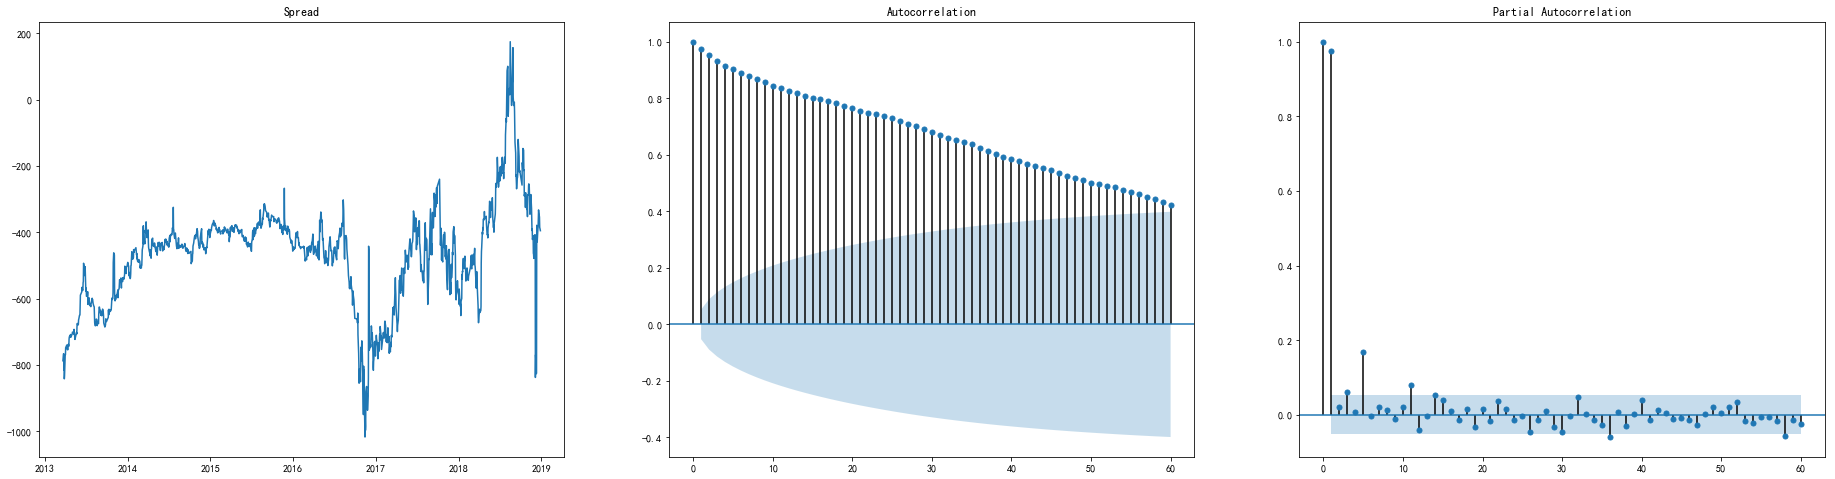

In [81]:
# --------协整检验--------
Mask = (pd.notnull(CCPrice.values[:, 0]) & pd.notnull(CCPrice.values[:, 1]))
CointADFTest = sm.tsa.stattools.coint(CCPrice.values[:, 0][Mask], CCPrice.values[:, 1][Mask], trend="c", autolag="BIC")
print(("----------- %s Cointegration ADF Test -----------" % ("-".join(CCPrice.columns), )),
      ("Statistic: %f" % CointADFTest[0]), 
      ("pvalue : %f" % CointADFTest[1]), sep="\n")

CointJohansenTest = sm.tsa.var.vecm.coint_johansen(CCPrice.values, det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print(("----------- %s Cointegration Johansen Test: r<=%d -----------" % ("-".join(CCPrice.columns), i)),
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

Spread = (CCPrice * HedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(Spread)
Axes[0].set_title("Spread")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

HalfLife: 28.253704


,0
起始时点,2013-03-22 00:00:00
结束时点,2018-12-28 00:00:00
时点数,1408
总收益率,0.0533989
年化收益率,0.00905261
年化波动率,0.0877128
Sharpe比率,0.103207
胜率,0.619318
最大回撤率,0.190461
最大回撤开始时点,2018-03-22 00:00:00


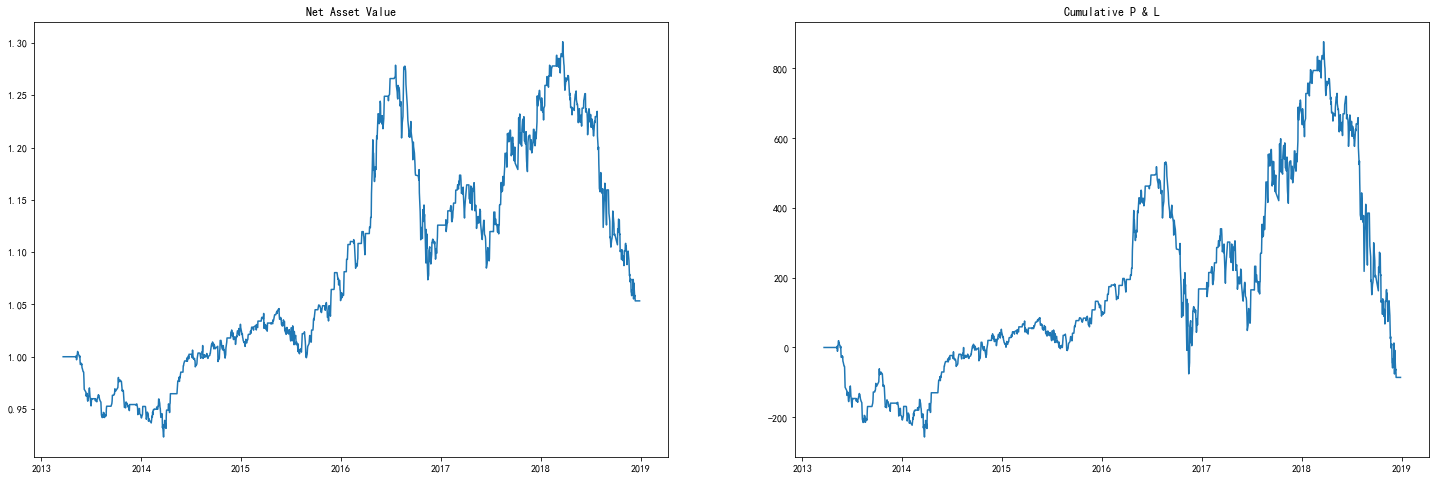

In [89]:
# --------Spread 策略--------
EntryThreshold, ExitThreshold = 1, 0
# NumRatio = np.array([1, -1.4])
# NumRatio = np.array([1, -1.33])
NumRatio = HedgeRatio

# 生成信号
Spread = (CCPrice * NumRatio).sum(axis=1)
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)
# LookBack = 10
LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.full(shape=(CCPrice.shape[0], ), fill_value=np.nan)
# 空头信号
Mask = (Zscore.values>EntryThreshold)
NumUnits[Mask] = -1
# 多头信号
Mask = (Zscore.values<-EntryThreshold)
NumUnits[Mask] = 1
# 平仓信号
PreNumUnits = pd.Series(NumUnits).fillna(method="pad").values
NumUnits[(PreNumUnits==1) & (Zscore.values>=-ExitThreshold)] = 0
NumUnits[(PreNumUnits==-1) & (Zscore.values<=ExitThreshold)] = 0
# 填充缺失
NumUnits[0] = (0 if pd.isnull(NumUnits[0]) else NumUnits[0])
NumUnits = pd.Series(NumUnits).fillna(method="pad").values
# 策略回测
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(NumRatio.shape[0], axis=1) * NumRatio
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * CCPrice.values / AdjCCPrice.values, AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

借鉴 \cite{DZQH:TianZhongze:2017:1} 中给出的策略构建方式：
* 开仓条件：价差在 10 日均值加（减） 1 倍标准差和 1.2 倍标准差之间，且有回归趋势，做空（多）价差；
* 平仓条件：价差回归到 10 日均值；
* 止损：2%，止损后 10 日内不再开仓；
* 换仓：主力合约到期前 1 个月换仓；
* 滑点：一个最小变动价位
* 手续费：2%%

,0
起始时点,2013-03-22 00:00:00
结束时点,2018-12-28 00:00:00
时点数,1408
总收益率,0.0268248
年化收益率,0.00459621
年化波动率,0.0310573
Sharpe比率,0.147991
胜率,0.976562
最大回撤率,0.0429552
最大回撤开始时点,2016-11-08 00:00:00


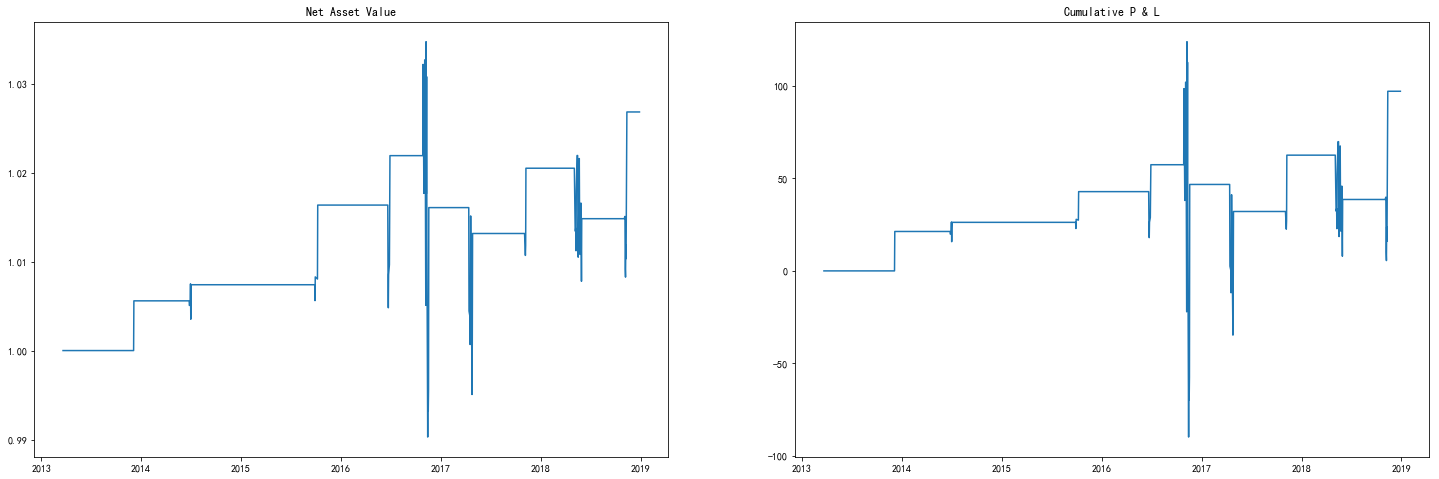

In [86]:
# --------Spread 策略--------
EntrThreshold, ExitThreshold, EntryUpThreshold = 1, 0, 1.2
# NumRatio = np.array([1, -1.4])
# NumRatio = np.array([1, -1.33])
NumRatio = HedgeRatio

# 生成信号
Spread = (CCPrice * NumRatio).sum(axis=1)
LookBack = 10
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.full(shape=(CCPrice.shape[0], ), fill_value=np.nan)
# 空头信号
Mask = (Zscore.values>EntryThreshold)
Mask = (Mask & (Zscore.values<EntryUpThreshold))
Mask = (Mask & (Spread.rolling(LookBack).mean().diff().values<0))
NumUnits[Mask] = -1
# 多头信号
Mask = (Zscore.values<-EntryThreshold)
Mask = (Mask & (Zscore.values>-EntryUpThreshold))
Mask = (Mask & (Spread.rolling(LookBack).mean().diff().values>0))
NumUnits[Mask] = 1
# 平仓信号
PreNumUnits = pd.Series(NumUnits).fillna(method="pad").values
NumUnits[(PreNumUnits==1) & (Zscore.values>=-ExitThreshold)] = 0
NumUnits[(PreNumUnits==-1) & (Zscore.values<=ExitThreshold)] = 0
# 填充缺失
NumUnits[0] = (0 if pd.isnull(NumUnits[0]) else NumUnits[0])
NumUnits = pd.Series(NumUnits).fillna(method="pad").values
# 策略回测
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(NumRatio.shape[0], axis=1) * NumRatio
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * CCPrice.values / AdjCCPrice.values, AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


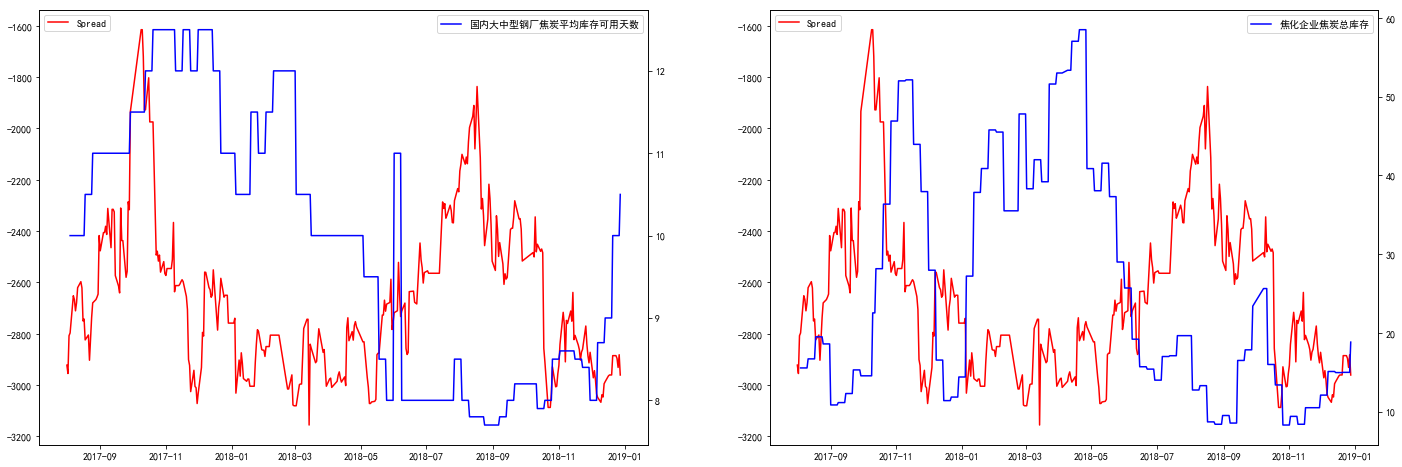

In [45]:
# 获取基本面因子数据
FundamentalFactor = pd.DataFrame(index=DTs, columns=[])

w.start()
TempData = w.edb("S5118225, S5133394", StartDT.strftime("%Y-%m-%d"), EndDT.strftime("%Y-%m-%d"),"Fill=Previous")
TempData = pd.DataFrame(TempData.Data, index=["国内大中型钢厂焦炭平均库存可用天数", "焦化企业焦炭总库存"],
                        columns=[dt.datetime.combine(iDate, dt.time(0)) for iDate in TempData.Times]).T
FundamentalFactor = pd.merge(FundamentalFactor, TempData.loc[TempData.index.union(DTs)].fillna(method="pad").loc[DTs], left_index=True, right_index=True)
w.close()

nID = FundamentalFactor.shape[1]
nRow, nCol = nID//3+(nID%3!=0), min(3, nID)
Fig = plt.figure(figsize=(min(32, 16+(nCol-1)*8), 8*nRow))
AxesGrid = gridspec.GridSpec(nRow, nCol)
for i in range(nID):
    iAxes = plt.subplot(AxesGrid[i//nCol, i%nCol])
    iAxes.plot(Spread.index, Spread.values, color='r', label="Spread")
    iAxes.legend(loc='upper left')
    RAxes = iAxes.twinx()
    RAxes.plot(FundamentalFactor.index, FundamentalFactor.values[:, i], color='b', label=FundamentalFactor.columns[i])
    RAxes.legend(loc='upper right');

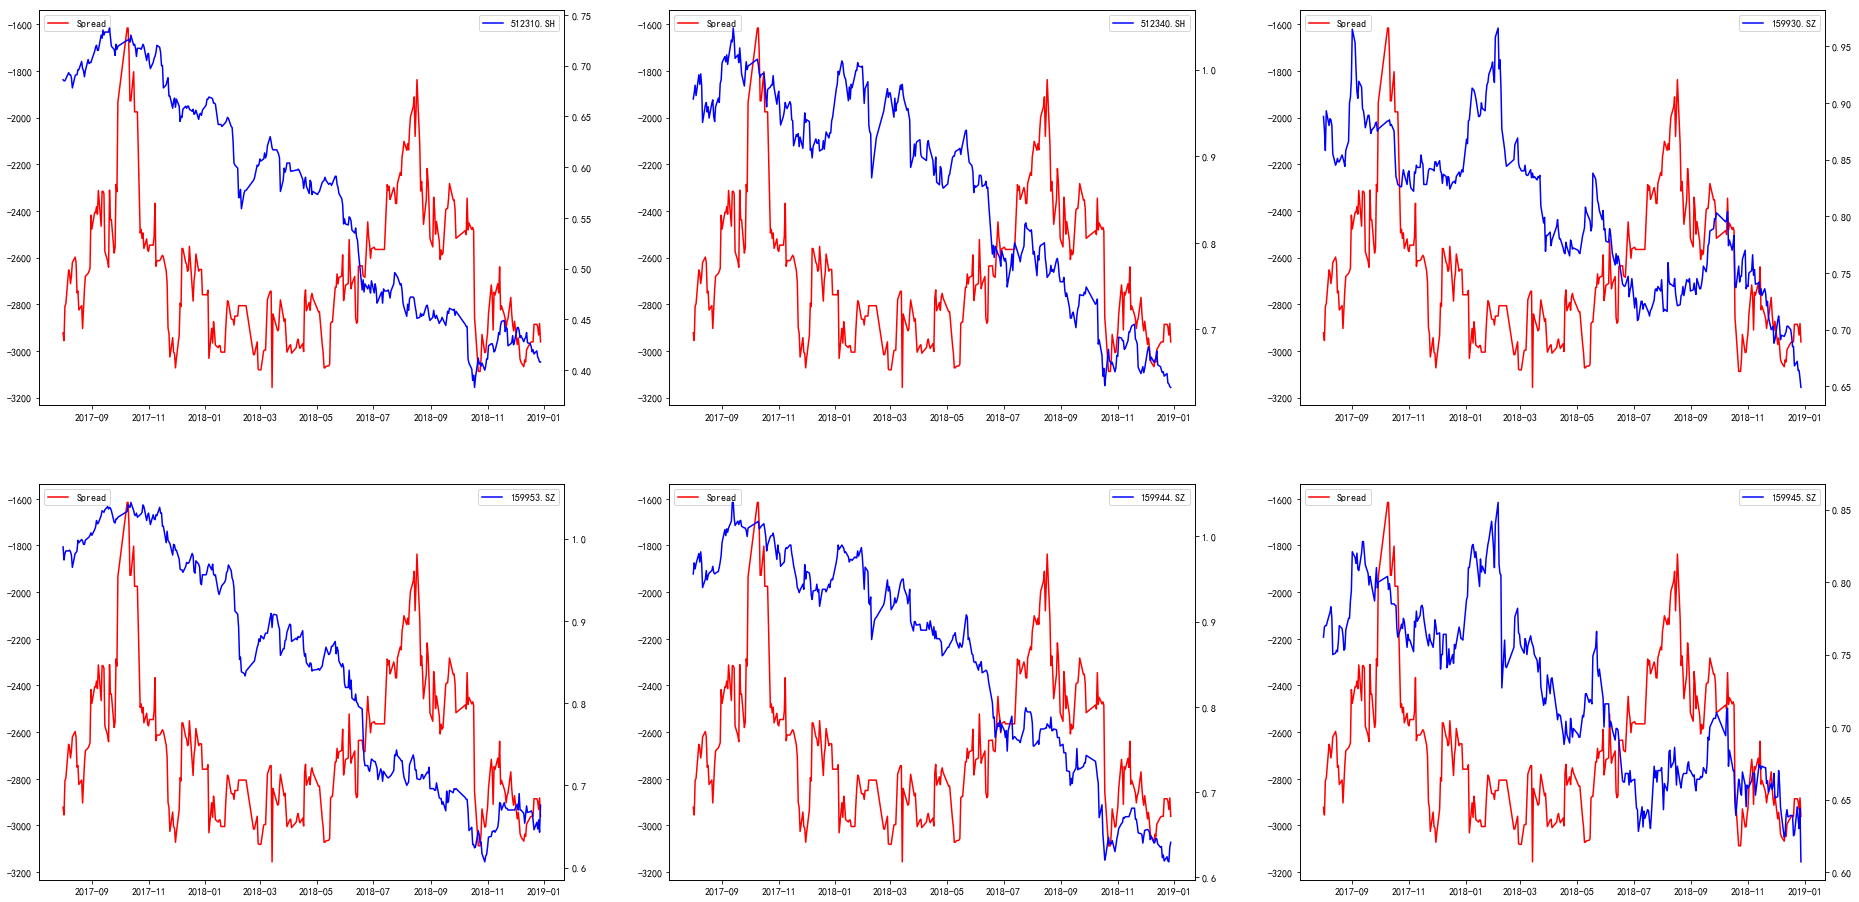

In [61]:
# ETF 数据
ETFIDs = ["512310.SH", "512340.SH", "159930.SZ", "159953.SZ", "159944.SZ", "159945.SZ"]# 500 原料 ETF
ETFPrice = pd.DataFrame(index=DTs, columns=[])

WDB.connect()
FT = WDB.getTable("中国封闭式基金日行情")
for iID in ETFIDs:
    TempData = FT.readData(factor_names=["收盘价(元)", "复权因子"], ids=[iID], dts=DTs).iloc[:, :, 0]
    # 对 ETF 价格进行复权调整
    ETFPrice[iID] = TempData.iloc[:, 0] / TempData.iloc[-1, 1] * TempData.iloc[:, 1]# 前复权
WDB.disconnect()

nID = ETFPrice.shape[1]
nRow, nCol = nID//3+(nID%3!=0), min(3, nID)
Fig = plt.figure(figsize=(min(32, 16+(nCol-1)*8), 8*nRow))
AxesGrid = gridspec.GridSpec(nRow, nCol)
for i in range(nID):
    iAxes = plt.subplot(AxesGrid[i//nCol, i%nCol])
    iAxes.plot(Spread.index, Spread.values, color='r', label="Spread")
    iAxes.legend(loc='upper left')
    RAxes = iAxes.twinx()
    RAxes.plot(ETFPrice.index, ETFPrice.values[:, i], color='b', label=ETFPrice.columns[i])
    RAxes.legend(loc='upper right');

----------- Cointegration Johansen Test: r<=0 -----------
Trace Statistic: 15.952477
Critical Values (90%, 95%, 99%): [27.0669 29.7961 35.4628]
Maximum Eigenvalue Statistic Statistic: 8.761108
Critical Values (90%, 95%, 99%): [18.8928 21.1314 25.865 ]
----------- Cointegration Johansen Test: r<=1 -----------
Trace Statistic: 7.191370
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 6.172417
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- Cointegration Johansen Test: r<=2 -----------
Trace Statistic: 1.018953
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 1.018953
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
对冲比例: [ 1.00000000e+00 -5.47292232e+00 -1.80969328e+03]


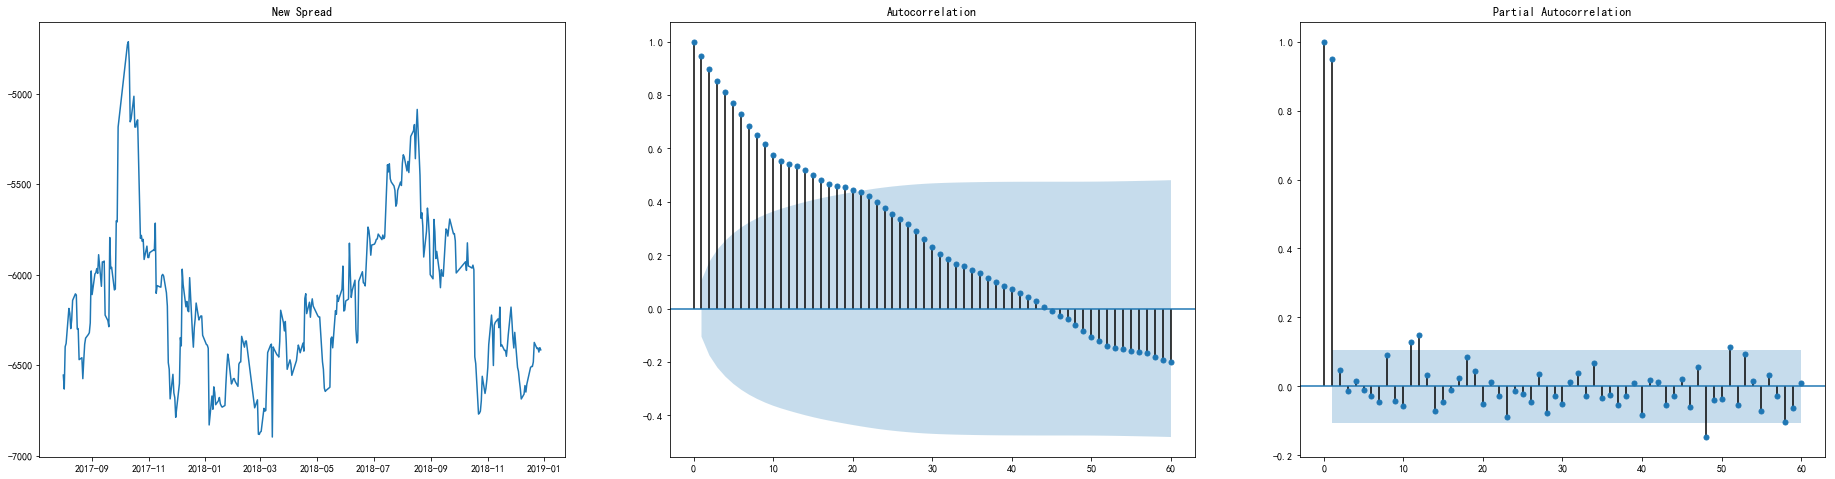

In [62]:
# --------协整检验--------
ETFID = "159945.SZ"
Price = pd.DataFrame(np.c_[CCPrice.values, ETFPrice[ETFID].values], index=DTs, columns=CCPrice.columns.tolist()+[ETFID])
CointJohansenTest = sm.tsa.var.vecm.coint_johansen(Price.values, det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print(("----------- Cointegration Johansen Test: r<=%d -----------" % (i, )),
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

NewSpread = (Price * HedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(NewSpread)
Axes[0].set_title("New Spread")
sm.graphics.tsa.plot_acf(NewSpread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(NewSpread, lags=60, ax=Axes[2]);

# References

[<a id="cit-DZQH:TianZhongze:2017:1" href="#call-DZQH:TianZhongze:2017:1">DZQH:TianZhongze:2017:1</a>] 田钟泽; 罗鑫明;, ``_商品期货套利实证_'',  2017.

